In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import eye_array
import scipy.sparse.linalg as sla
import pymrm as mrm
from pymrm import construct_grad, construct_div, numjac_local, newton, clip_approach

In [42]:
class MulticomponentDiffusion:
    def __init__(self):
        self.D = 1e-5
        self.L = 0.01
        self.num_x = 100
        self.num_c = 4
        self.bc = {'a': [0, 0], 'b': [1, 1], 'd':[ [[1, 0, 0, 0]], [[0, 1, 0, 0]]]}
        self.k1 = 1e6
        self.k2 = 0.0
        self.dt = 0.1
        self.x_f = np.linspace(0,self.L,self.num_x+1)
        self.x_c = 0.5*(self.x_f[0:-1]+self.x_f[1:])
        self.init_field()
        self.init_Jac()
        self.freq_out = 10
    
    def init_field(self, c0=0.0):
        self.c = np.full((self.num_x,self.num_c),c0, dtype='float')
    
    def init_Jac(self):
        Grad, grad_bc = construct_grad(self.c.shape, self.x_f, self.x_c, self.bc, axis = 0)
        self.Div = construct_div(self.c.shape, self.x_f, nu=0, axis = 0)   
        self.Flux = -self.D * Grad
        self.flux_bc = -self.D * grad_bc
        Jac_accum = (1.0/self.dt)*eye_array(self.num_x*self.num_c,format='csc')
        self.g_const = self.Div @ self.flux_bc
        self.Jac_const = Jac_accum + self.Div@self.Flux
    
    def reaction(self,c):
        r = self.k1*c[:,0]*c[:,1]-self.k2*c[:,2]*c[:,3]
        return np.array([[1,1,-1,-1]])*r.reshape((-1,1))
        
    def construct_Jac(self, c, c_old):
        g_react, Jac_react = numjac_local(self.reaction, c, axis = -1)
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) - c_old.reshape((-1,1))/self.dt - g_react.reshape((-1,1))
        Jac = self.Jac_const - Jac_react
        return g,Jac
        
    def solve(self, num_timesteps):
        Jac = self.Jac_const
        for i in range(num_timesteps):
            c_old = self.c.copy()        
            result = newton(lambda c: self.construct_Jac(c, c_old), c_old, maxfev = 5, callback = clip_approach)
            self.c = result.x
            if (i % self.freq_out == 0):
                plt.plot(self.x_c,self.c)
        plt.xlabel('Position')
        plt.ylabel('Concentration')
        plt.show()

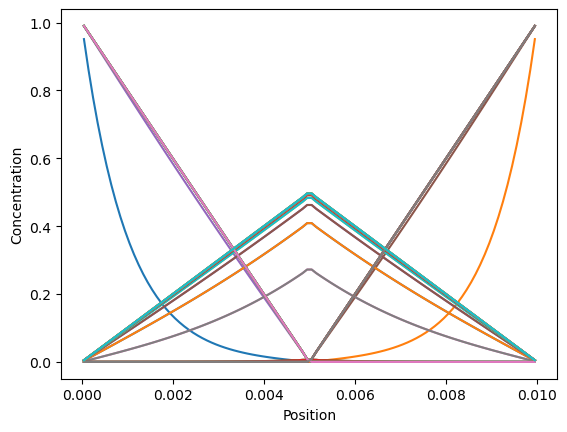

In [44]:
mrm_problem = MulticomponentDiffusion()
mrm_problem.solve(100)